In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import pymysql  
from haversine import haversine
from bisect import bisect_left, bisect_right

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# NLP 
import re
from konlpy.tag import Okt

!pip install glove_python
from glove import Corpus, Glove

# Crawling 
import requests
from bs4 import BeautifulSoup

# Clustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import metrics
from scipy.spatial.distance import cdist

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

Using Python-MIP package version 1.5.3


In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [3]:
# pydeck function 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 
 
def multipolygon_to_center_coordinates(x): 
    lon, lat = x[0].centroid.xy 
    return [[x, y] for x, y in zip(lon, lat)]

def polygon_to_center_coordinates(x): 
    lon, lat = x.centroid.xy
    return [[x, y] for x, y in zip(lon, lat)] 

In [4]:
token = "pk.eyJ1IjoiZGx3b3FsczQzMjMiLCJhIjoiY2tscnR3bG95MDJwaDJ2bjUzcTBrc3h4cyJ9.WigDFX0Gm612haaz4zQ2hg"
key = '8H1yac%2Bb0yetY2Waad%2BQIRU43O17onRUd7iR0k2p6%2B4i0yNYn3ym0cXgt3ZqWrR9uFw%2BDu%2B5quHbsXxjpsw5ng%3D%3D'

# 1. Bus Data  
* df_01 + df_07 
* df_02 ~ df_06 
---
* **경기 버스 정보** : http://www.gbis.go.kr/
* GGD_RouteInfo_M.xls : 버스 노선 정보 (기점, 종점 / 주중배차간격, 주말배차간격 / 첫차, 막차 시간) 
* GGD_RouteStationInfo_M.xls : 노선 경유 정보 (버스 노선 순서) 

## 1-1. tmp : df_01 + df_07 
* 버스 정보 합치기 
* 전처리 

In [5]:
# BIS = 1 & 인도 폭 0 or 4 이상인 정류장만 분석에 이용 
sidewalk = gpd.read_file(current_path+'/data/bus_filter_final.geojson')
sidewalk = sidewalk.drop(["layer", "path", "geometry"], axis=1)
sidewalk = sidewalk.drop_duplicates(["정류장ID"])

print(sidewalk.shape)
sidewalk.head()

(519, 14)


,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
0,201000345,남수원초등학교,시내,일반,경기도 수원시 세류2동,nan,1,nan,nan,nan,1.000000,None,127.016000,37.251091
1,201000268,곡반중학교,시내,일반,경기도 수원시 곡선동,1.000000,1,1.000000,nan,nan,nan,None,127.034254,37.246081
2,201000357,수원은혜교회.한양수자인파크원아파트,시내,일반,경기도 수원시 금곡동,1.000000,1,nan,1.000000,nan,nan,None,126.953978,37.266016
3,202000090,화서역,"시내,마을",일반,경기도 수원시 화서2동,1.000000,1,nan,nan,1.000000,nan,None,126.990107,37.283895
4,202000092,월드메르디앙,시내,일반,경기도 수원시 우만2동,nan,1,nan,nan,1.000000,nan,None,127.037045,37.280164


In [6]:
tmp = sidewalk.merge(df_07[['정류소ID', '운행노선', '중앙차로여부']], how = 'left', left_on = '정류장ID', right_on = '정류소ID', copy = False)
del tmp['정류소ID']

## 1-2. tmp data preprocessing 

In [7]:
tmp.환승역타입 = '일반'
tmp.쉘터 = tmp.쉘터.fillna(0)

# LED / LCD / LED+LCD 
tmp.LED = tmp.LED.fillna(0)
tmp.LCD = tmp.LCD.fillna(0)
tmp['LED+LCD복합형'] = tmp['LED+LCD복합형'].fillna(0)

# 알뜰형 / 임대형(음성) 
tmp.알뜰형 = tmp.알뜰형.fillna(0)
tmp['임대형(음성)'] = tmp['임대형(음성)'].fillna(0)

# 운행노선 & 중앙차로여부 없는 데이터 2개 drop 
tmp = tmp.dropna(axis=0)

## 1-3. df_02 ~ df_06 

In [8]:
df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)
df_02_06.shape

(2508607, 12)

In [9]:
# 노선번호 object 형태로 맞춰주기 
tqdm.pandas()
df_02_06["노선번호"] = df_02_06["노선번호"].progress_apply(lambda x : str(x))

# '92' 처럼 용남고속 & 수원여객 동시운행 버스 통합  
df_02_06 = df_02_06.groupby(by=['일자', '정류소ID', '노선번호', '노선유형']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()
df_02_06 = df_02_06.drop(['하차 건수','미태그 건수'], axis=1)

100%|██████████| 2508607/2508607 [00:03<00:00, 794999.25it/s]


In [10]:
# 기존 버스 데이터에 합치기 
bus = df_02_06.merge(tmp, how='left', left_on = '정류소ID', right_on = '정류장ID', copy = True).drop(['정류장ID'], axis=1)

# BIS 미설치 정류장 & 인도 폭 기준 미달 정류장 제외 
bus = bus.dropna(axis=0)

In [11]:
print("df_01 unique 정류장 ID 개수 : ", df_01["정류장ID"].nunique())
print("df_02~06 unique 정류장 ID 개수 : ", df_02_06["정류소ID"].nunique())

print("=====" * 20)
print("합치기 전 unique 정류장 ID 개수 : ", tmp["정류장ID"].nunique())
print("합친 후의 unique 정류장 ID 개수 : ", bus["정류소ID"].nunique())

df_01 unique 정류장 ID 개수 :  1179
df_02~06 unique 정류장 ID 개수 :  1114
합치기 전 unique 정류장 ID 개수 :  518
합친 후의 unique 정류장 ID 개수 :  516


## 1-4. 외부데이터 

In [12]:
route = pd.read_excel(current_path+'/data/GGD_RouteInfo_M.xls')
trans = pd.read_excel(current_path+'/data/GGD_RouteStationInfo_M.xls', sheet_name=[0,1,2])

trans = pd.concat([trans[0], trans[1], trans[2]], axis=0, ignore_index = True)

### (1) 버스 노선 순서 데이터 

In [13]:
# 버스 노선 순서 데이터 
trans2 = trans.rename(columns = {"STATION_ID": "정류소ID", "ROUTE_ID": "노선ID", "ROUTE_NM": "노선번호", "STA_ORDER": "노선순서", "STATION_NM": "정류장명"})
trans2 = trans2.drop(["순번", "MOBILE_NO"], axis=1)

# 노선 번호 전처리 
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : str(x))
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

100%|██████████| 192708/192708 [00:00<00:00, 734462.46it/s]


In [14]:
# Data Merge 
tmp2 = bus.merge(trans2.drop(["정류장명"], axis=1), how='left', on=['정류소ID', '노선번호'])
print("bus+trans shape : ", tmp2.shape , '\n') 
print("원래 데이터의 unique bus 개수 : ", bus.정류소ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp2.정류소ID.nunique())
print("=====" * 20)
tmp2.head(2)

bus+trans shape :  (1364613, 25) 

원래 데이터의 unique bus 개수 :  516
합친 데이터의 unique bus 개수 :  516


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서
0,20200101,200000006,13,일반형시내버스,166,160,6,67,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000037.000000,13.000000
1,20200101,200000006,37,일반형시내버스,36,33,3,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000099.000000,1.000000


### (2) 버스 노선 정보 데이터 

In [15]:
route["노선번호"] = route["노선번호"].progress_apply(lambda x : str(x))
route["노선번호"] = route["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

route = route[route["하행첫차"] != '1899/1']
print(route.shape)

100%|██████████| 3480/3480 [00:00<00:00, 621193.26it/s]

(3479, 15)


In [16]:
# 상행첫차, 상행막차, 하행첫차, 하행막차 type 바꿔주기 
route['상행첫차'] = route['상행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['상행막차'] = route['상행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['하행첫차'] = route['하행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['하행막차'] = route['하행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))

100%|██████████| 3479/3479 [00:00<00:00, 5200.45it/s]


In [17]:
# 운행시간 구하기 
def operation_time(first, last) : 
    if last >= first  : 
        return last - first 
    else : 
        last += timedelta(days=1)
        return last - first 

In [18]:
route["상행운행시간"] = route.progress_apply(lambda x : operation_time(x["상행첫차"], x["상행막차"]), axis=1)
route["하행운행시간"] = route.progress_apply(lambda x : operation_time(x["하행첫차"], x["하행막차"]), axis=1)

100%|██████████| 3479/3479 [00:00<00:00, 13563.28it/s]


In [19]:
# Data Merge 
tmp3 = pd.merge(left=tmp2, right=route.drop(["순번"], axis=1).drop_duplicates('노선ID'), how='left', \
                on=['노선ID','노선번호'])

print("bus+trans+route shape : ", tmp3.shape , '\n') 
print("bus 데이터의 unique bus 개수 : ", bus.정류소ID.nunique())
print("tmp2 데이터의 unique bus 개수 : ", tmp2.정류소ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp3.정류소ID.nunique())
print("=====" * 20)
tmp3.head()

bus+trans+route shape :  (1364613, 39) 

bus 데이터의 unique bus 개수 :  516
tmp2 데이터의 unique bus 개수 :  516
합친 데이터의 unique bus 개수 :  516


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간
0,20200101,200000006,13,일반형시내버스,166,160,6,67,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000037.000000,13.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00
1,20200101,200000006,37,일반형시내버스,36,33,3,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000099.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,한국민속촌.보라해링턴,228001646.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00
2,20200101,200000006,7_1,일반형시내버스,187,162,25,190,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000045.000000,55.000000,수원시,수원여객,동탄차고지,233001222.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00
3,20200101,200000008,13,일반형시내버스,127,127,0,46,문암골,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.027700,37.308946,13(수원여객),노변정류장,200000037.000000,11.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00
4,20200101,200000036,112,일반형시내버스,36,34,2,76,풍림아파트입구,"시내,마을",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,126.995257,37.297929,112(수원여객),노변정류장,200000049.000000,29.000000,수원시,수원여객,곡반정동차고지,201000143.000000,웅비아파트,201000330.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00


## 1-5. dataframe split 
* 결측값 문제를 해결하기 위해 일단 데이터 split 
* 노선 정보가 없는 데이터는 고려하지 않아도 괜찮을 것이라 판단  

In [20]:
# 결측값 없는 dataframe index 
idx = tmp3.dropna(axis=0).index

final = tmp3.loc[idx]
final_na = tmp3[~tmp3.index.isin(idx)]

# check 
print("* 결측값 제외한 dataframe shape : ", final.shape) 
print("* 결측값 제외한 dataframe unique 버스정류장 개수 :", final.정류소ID.nunique())
print("=====" * 20)
print("* 결측값 있는 dataframe shape : ", final_na.shape)  
print("* 결측값 있는 dataframe unique 버스정류장 개수 :", final_na.정류소ID.nunique())

tmp3.shape[0] == (final.shape[0] + final_na.shape[0])

* 결측값 제외한 dataframe shape :  (1326103, 39)
* 결측값 제외한 dataframe unique 버스정류장 개수 : 516
* 결측값 있는 dataframe shape :  (38510, 39)
* 결측값 있는 dataframe unique 버스정류장 개수 : 173


True

## 1-6. 추가 전처리 

In [21]:
# 일자 data type 바꿔주기 (오래걸림)
final['일자'] = final['일자'].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

100%|██████████| 1326103/1326103 [04:52<00:00, 4540.78it/s]


In [22]:
# 중앙차로여부 
final["중앙차로여부"] = final["중앙차로여부"].progress_apply(lambda x : 1 if x == '중앙차로 정류장' else 0)

100%|██████████| 1326103/1326103 [00:01<00:00, 735168.80it/s]


In [23]:
# 운행노선 / 정류장유형 
final["운행노선"] = final["운행노선"].progress_apply(lambda x : x.split(','))
final["운행노선수"] = final["운행노선"].progress_apply(lambda x : len(x))

final["정류장유형"] = final["정류장유형"].progress_apply(lambda x : x.split(','))
final["정류장유형수"] = final["정류장유형"].progress_apply(lambda x : len(x))

100%|██████████| 1326103/1326103 [00:01<00:00, 713396.66it/s]


## 1-7. Bus Stop Data 
* **busstop** : tmp (버스 고유 정보) + route + trans 
* 일별 정보 없는 **버스 정류장** 데이터

In [24]:
busstop = final.drop(['일자', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)
busstop = busstop.drop_duplicates(["정류소ID", "노선번호", '노선유형'])

# 해당 노선의 총 승차건수 데이터 평균 
busstop_tmp = final.groupby(by=['정류소ID', '노선번호', '노선유형']).mean([['전체승차건수','초승건수','환승건수','전체하차건수']]).reset_index()

# Data Merge 
busstop = pd.merge(left=busstop, right=busstop_tmp[['정류소ID', '노선번호', '노선유형', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수']], 
                   how='left', on=['정류소ID', '노선번호', '노선유형'])

print("bus 노선 정보 dataframe shape : ", busstop.shape , '\n') 
print("합친 데이터의 unique bus 개수 : ", busstop.정류소ID.nunique())
print("=====" * 20)
busstop.head()

bus 노선 정보 dataframe shape :  (3926, 40) 

합친 데이터의 unique bus 개수 :  516


,정류소ID,노선번호,노선유형,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수
0,200000006,13,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000037.000000,13.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1,212.605479,206.279452,6.326027,51.257534
1,200000006,37,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000099.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,한국민속촌.보라해링턴,228001646.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1,48.726027,43.556164,5.169863,4.813699
2,200000006,7_1,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000045.000000,55.000000,수원시,수원여객,동탄차고지,233001222.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1,237.380822,213.057534,24.323288,210.950685
3,200000008,13,일반형시내버스,문암골,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.027700,37.308946,[13(수원여객)],0,200000037.000000,11.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,1,1,77.498630,77.200000,0.298630,36.594521
4,200000036,112,일반형시내버스,풍림아파트입구,"[시내, 마을]",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,126.995257,37.297929,[112(수원여객)],0,200000049.000000,29.000000,수원시,수원여객,곡반정동차고지,201000143.000000,웅비아파트,201000330.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00,1,2,73.186301,66.775342,6.410959,99.109589


# 2. Bus Data Feature Engineering 
1. **tmp** (518, 16) : 버스 정류장 고유 정보 데이터, df_01 + df_07 
2. **busstop** (3921, 36) : tmp (버스 고유 정보) + route + trans
3. **final** (1326103, 43) : 일별 노선 승하차 정보 포함 데이터 

## 2-1. busstop data Feature Engineering 
* 버스 노선 고유 정보 feature engineering 

### (1) 버스 유형 

In [25]:
busstop = pd.get_dummies(busstop, columns=["노선유형"])

### (2) 노선 별 승차 건수 비율 

In [26]:
def div(col1, col2) : 
    try : 
        return col1 / col2 
    except : 
        return 0 

In [27]:
# 초승 환승 전체승차 하차 
busstop["초승_환승비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['환승 건수']), axis=1)
busstop["초승_승차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체 승차 건수']), axis=1)
busstop["초승_하차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체 하차 건수']), axis=1)

busstop["환승_승차비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체 승차 건수']), axis=1)
busstop["환승_하차비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체 하차 건수']), axis=1)

busstop["승차_하차비율"] = busstop.progress_apply(lambda x : div(x['전체 승차 건수'], x['전체 하차 건수']), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 17979.11it/s]


### (3) 승차 많은 / 환승 많은 / 하차 많은 버스 노선 
* 분모 : 전체 승차 건수 + 전체 하차 건수 
* 분자 : 승차 건수 / 환승 건수 / 하차 건수 

In [28]:
busstop["전체승하차건수"] = busstop.progress_apply(lambda x : x['전체 승차 건수'] + x['전체 하차 건수'], axis=1)

busstop["승차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체승하차건수']), axis=1)
busstop["환승비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체승하차건수']), axis=1)
busstop["하차비율"] = busstop.progress_apply(lambda x : div(x['전체 하차 건수'], x['전체승하차건수']), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 18070.48it/s]


In [29]:
def ratio_threshold(threshold, data, column):  
    cnt = 0
    for ratio in data[column]:
        if ratio >= threshold:
            cnt = cnt + 1
    print("{}이 {} 이상인 버스 정류장의 비율 : {:.4f} & 버스 정류장의 개수 : {}".format(column, threshold, (cnt/len(data[column])), cnt))

In [30]:
ratio_threshold(0.65, busstop, "승차비율")
ratio_threshold(0.2, busstop, "환승비율")
ratio_threshold(0.8, busstop, "하차비율")

승차비율이 0.65 이상인 버스 정류장의 비율 : 0.1755 & 버스 정류장의 개수 : 689
환승비율이 0.2 이상인 버스 정류장의 비율 : 0.1271 & 버스 정류장의 개수 : 499
하차비율이 0.8 이상인 버스 정류장의 비율 : 0.1783 & 버스 정류장의 개수 : 700


In [31]:
busstop["승차많은버스"] = busstop["승차비율"].progress_apply(lambda x : 1 if x > 0.65 else 0)
busstop["환승많은버스"] = busstop["환승비율"].progress_apply(lambda x : 1 if x > 0.2 else 0)
busstop["하차많은버스"] = busstop["하차비율"].progress_apply(lambda x : 1 if x > 0.8 else 0)

100%|██████████| 3926/3926 [00:00<00:00, 614870.15it/s]


In [32]:
'''
<mean>
승하차 비율  

<sum>
승하차 건수
노선 유형
승하차 많은 버스 
'''

temp_mean = busstop[['정류소ID'] + list(busstop.columns[busstop.columns.str.contains("비율")])].groupby('정류소ID').mean().reset_index()
temp_sum  = busstop[['정류소ID'] + list(busstop.columns[busstop.columns.str.contains("건수|노선유형|많은")])].groupby('정류소ID').sum().reset_index()

temp_mean.shape, temp_sum.shape

((516, 10), (516, 15))

### (4) 첫차 / 막차 시간 

In [33]:
# 첫차 : 가장 빠른 시간 , 막차 : 가장 늦은 시간 
time1 = busstop.sort_values('상행첫차').groupby('정류소ID').first().reset_index()
time2 = busstop.sort_values('상행막차').groupby('정류소ID').last().reset_index()
time3 = busstop.sort_values('하행첫차').groupby('정류소ID').first().reset_index()
time4 = busstop.sort_values('하행막차').groupby('정류소ID').last().reset_index()

time1.shape, time2.shape, time3.shape, time4.shape

((516, 58), (516, 58), (516, 58), (516, 58))

### (5) Data Merge 
* **busstop** : 버스 정류장 정보, 분석에 필요한 column 만 keep 
* **temp_mean / temp_sum** : 버스 노선 정보 통계량 
* **time** : 첫차 / 막차 시간 

In [34]:
# busstop 
busdf = busstop[['정류소ID', '정류장명', '쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형', 'lon', 'lat', 
                 '중앙차로여부', '운행노선수', '정류장유형수']].drop_duplicates(['정류소ID']).reset_index(drop=True)  

# temp_mean / temp_sum 
busdf = busdf.merge(temp_mean, how='left', on='정류소ID')
busdf = busdf.merge(temp_sum, how='left', on='정류소ID')

# time 
busdf = busdf.merge(time1[["정류소ID", '상행첫차']], on = '정류소ID', how='left')
busdf = busdf.merge(time2[["정류소ID", '상행막차']], on = '정류소ID', how='left')
busdf = busdf.merge(time3[["정류소ID", '하행첫차']], on = '정류소ID', how='left')
busdf = busdf.merge(time4[["정류소ID", '하행막차']], on = '정류소ID', how='left')

In [35]:
# 버스 정류장 운행 시간 
busdf["상행버스정류장운행시간"] = busdf.progress_apply(lambda x : operation_time(x["상행첫차"], x["상행막차"]), axis=1)
busdf["하행버스정류장운행시간"] = busdf.progress_apply(lambda x : operation_time(x["하행첫차"], x["하행막차"]), axis=1)

# 운행 시간 (hr 기준)
busdf["상행버스정류장운행시간"] = busdf["상행버스정류장운행시간"].progress_apply(lambda x : x.seconds / 3600)
busdf["하행버스정류장운행시간"] = busdf["하행버스정류장운행시간"].progress_apply(lambda x : x.seconds / 3600)

busdf = busdf.drop(['상행첫차', '상행막차', '하행첫차', '하행막차'], axis=1)

100%|██████████| 516/516 [00:00<00:00, 98865.33it/s]


In [36]:
print(busdf.shape)
print("버스 정류장 unique 개수 : ", busdf.정류소ID.nunique())
print("=====" * 20)
busdf.head(3)

(516, 37)
버스 정류장 unique 개수 :  516


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333


## 2-2. final Data Feature Engineering 
* 일별 정보 반영 feature engineering 

### (1) 공통 전처리 

In [37]:
final2 = final.copy()
final2 = final2.drop(["정류장유형", "환승역타입", "위치(동)", "쉘터", "BIS설치여부", 'LED', 'LCD', 'LED+LCD복합형', 
                      '알뜰형', '임대형(음성)', 'lon', 'lat', '운행노선', '중앙차로여부', 
                      '정류장명', '노선ID', '노선순서', '관할관청', '운행업체', '기점', '기점_STATION_ID', '종점', '종점_STATION_ID', 
                      '상행첫차', '상행막차', '하행첫차', '하행막차'], axis=1)

In [38]:
print(final2.shape)
final2.head(2)

(1326103, 14)


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,주중배차간격,주말배차간격,상행운행시간,하행운행시간,운행노선수,정류장유형수
0,2020-01-01,200000006,13,일반형시내버스,166,160,6,67,5분~7분,5분~7분,0 days 16:00:00,0 days 17:30:00,9,1
1,2020-01-01,200000006,37,일반형시내버스,36,33,3,0,10분~13분,15분~20분,0 days 16:50:00,0 days 17:10:00,9,1


In [39]:
# 배차간격 
def interval(x) : 
    try : 
        itv = x.split("~")
        a, b = int(itv[0][:-1]), int(itv[1][:-1])
        return (a+b)/2
    except :
        return int(x[:-1])

In [40]:
# 분 단위 배차간격 
final2["주중배차간격(분)"] = final2["주중배차간격"].progress_apply(lambda x : interval(x))
final2["주말배차간격(분)"] = final2["주말배차간격"].progress_apply(lambda x : interval(x))

final2 = final2.drop(["주중배차간격", "주말배차간격"], axis=1)

100%|██████████| 1326103/1326103 [00:03<00:00, 364125.39it/s]


<AxesSubplot:xlabel='주말배차간격(분)', ylabel='Density'>

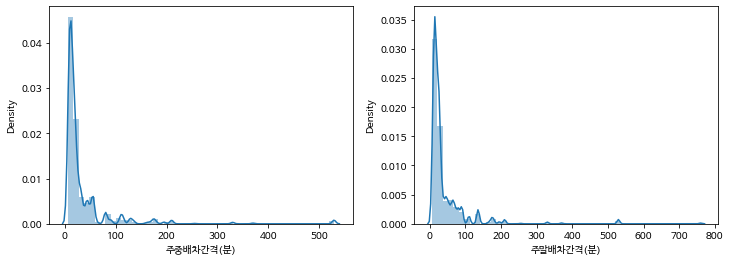

In [41]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.distplot(final2["주중배차간격(분)"], ax=ax1)
sns.distplot(final2["주말배차간격(분)"], ax=ax2)

In [42]:
print("주중 버스 배차 간격이 15분 이하인 버스의 개수 : {}".format(final2[final2["주중배차간격(분)"] < 15].노선번호.nunique()))
print("주중 버스 배차 간격이 60분 이상인 버스의 개수 : {}".format(final2[final2["주중배차간격(분)"] > 60].노선번호.nunique()))
print()
print("주말 버스 배차 간격이 15분 이하인 버스의 개수 : {}".format(final2[final2["주말배차간격(분)"] < 15].노선번호.nunique()))
print("주말 버스 배차 간격이 60분 이상인 버스의 개수 : {}".format(final2[final2["주말배차간격(분)"] > 60].노선번호.nunique()))

주중 버스 배차 간격이 15분 이하인 버스의 개수 : 47
주중 버스 배차 간격이 60분 이상인 버스의 개수 : 27

주말 버스 배차 간격이 15분 이하인 버스의 개수 : 28
주말 버스 배차 간격이 60분 이상인 버스의 개수 : 39


In [43]:
final2["주중배차간격_15분"] = final2["주중배차간격(분)"].progress_apply(lambda x : 1 if x < 15 else 0)
final2["주중배차간격_60분"] = final2["주중배차간격(분)"].progress_apply(lambda x : 1 if x > 60 else 0)

final2["주말배차간격_15분"] = final2["주말배차간격(분)"].progress_apply(lambda x : 1 if x < 15 else 0)
final2["주말배차간격_60분"] = final2["주말배차간격(분)"].progress_apply(lambda x : 1 if x > 60 else 0)

100%|██████████| 1326103/1326103 [00:01<00:00, 697166.55it/s]


In [44]:
final2["전체승하차건수"] = final2.progress_apply(lambda x : x['전체 승차 건수'] + x['전체 하차 건수'], axis=1)

final2["상행운행시간"] = final2["상행운행시간"].progress_apply(lambda x : x.total_seconds())
final2["하행운행시간"] = final2["하행운행시간"].progress_apply(lambda x : x.total_seconds())

100%|██████████| 1326103/1326103 [00:14<00:00, 90282.38it/s] 


In [45]:
def getHoliday(year):
    
    '''
    공공데이터포털 공휴일 데이터 
    '''
    
    url = f'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear={year}&ServiceKey={key}&_type=json&numOfRows=20'
    response = requests.get(url)
    holidays = response.json()['response']['body']['items']['item']
    holidays = pd.DataFrame(holidays)
    holidays['locdate'] = holidays['locdate'].astype(str).apply(lambda x : '-'.join([x[:4], x[4:6], x[6:]]))
    
    return holidays

In [46]:
# 공휴일 
holidays = getHoliday(2020)

final2 = final2.merge(holidays[['locdate', 'isHoliday']], left_on = final2['일자'].dt.date.astype(str), right_on = 'locdate', how = 'left').drop('locdate', axis = 1)
final2['공휴일'] = final2['isHoliday'].progress_apply(lambda x : 1 if x == 'Y' else 0)
final2 = final2.drop(["isHoliday"], axis=1)

# 주말 : 월 0 화 1 수 2 목 3 금 4 토 5 일 6 
final2["주말"] = final2["일자"].progress_apply(lambda x : 1 if x.weekday() in [5,6] else 0)

100%|██████████| 1326103/1326103 [00:11<00:00, 114781.61it/s]


In [144]:
# 주중, 주말, 공휴일 dataframe 
weekday = final2[(final2["주말"] == 0) & (final2["공휴일"] == 0)]  
weekend = final2[final2["주말"] == 1] 
holiday = final2[final2["공휴일"] == 1]  

weekday.shape, weekend.shape, holiday.shape

((914549, 21), (369827, 21), (62158, 21))

In [145]:
# 해당 노선의 총 승차건수 데이터 평균 
weekday = weekday.groupby(by=['정류소ID', '노선번호', '노선유형']).mean([['전체승차건수','초승건수','환승건수','전체하차건수']]).reset_index()
weekend = weekend.groupby(by=['정류소ID', '노선번호', '노선유형']).mean([['전체승차건수','초승건수','환승건수','전체하차건수']]).reset_index()
holiday = holiday.groupby(by=['정류소ID', '노선번호', '노선유형']).mean([['전체승차건수','초승건수','환승건수','전체하차건수']]).reset_index()

print("주중 데이터 shape : {} / 버스 정류장 unique 개수 : {}".format(weekday.shape, weekday.정류소ID.nunique()))
print("주말 데이터 shape : {} / 버스 정류장 unique 개수 : {}".format(weekend.shape, weekend.정류소ID.nunique()))
print("공휴일 데이터 shape : {} / 버스 정류장 unique 개수 : {}".format(holiday.shape, holiday.정류소ID.nunique()))

주중 데이터 shape : (3926, 20) / 버스 정류장 unique 개수 : 516
주말 데이터 shape : (3924, 20) / 버스 정류장 unique 개수 : 516
공휴일 데이터 shape : (3903, 20) / 버스 정류장 unique 개수 : 515


### (2) 대기시간노출도, 배차 횟수, 승차/환승/하차 비율 

#### 주중 

In [146]:
# 배차간격 * 승차건수 
def waiting(data, column) : 
    tmp = data[data["주중배차간격_60분"] == 0].groupby(['정류소ID']).max(f'{column}배차간격(분)')[f"{column}배차간격(분)"].reset_index().rename(columns = {f'{column}배차간격(분)': f"평균{column}배차간격"})
    data = data.merge(tmp, on="정류소ID", how="left")
    
    data[f"평균{column}배차간격"] = np.where(pd.notnull(data[f'평균{column}배차간격']) == True, data[f'평균{column}배차간격'], data[f'{column}배차간격(분)'])   
    data[f"{column}대기시간노출도"] = data.apply(lambda x : (x["전체 승차 건수"] * x[f"{column}배차간격(분)"]) if x[f"{column}배차간격_60분"] == 0 else (x["전체 승차 건수"] * x[f"평균{column}배차간격"]), axis=1)
    
    return data 

In [147]:
weekday = waiting(weekday, "주중")

In [148]:
# 주중 
weekday["주중상행배차횟수"] = weekday.progress_apply(lambda x : div(x['상행운행시간'], (x['주중배차간격(분)'] * 60)), axis=1)
weekday["주중하행배차횟수"] = weekday.progress_apply(lambda x : div(x['하행운행시간'], (x['주중배차간격(분)'] * 60)), axis=1)

weekday["주중배차횟수"] = weekday.progress_apply(lambda x : (x["주중상행배차횟수"] + x["주중하행배차횟수"]) / 2, axis=1)
weekday = weekday.drop(["주중상행배차횟수", "주중하행배차횟수"], axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 52389.93it/s]


In [149]:
weekday["주중승차비율"] = weekday.progress_apply(lambda x : div(x['초승 건수'], x['전체승하차건수']), axis=1)
weekday["주중환승비율"] = weekday.progress_apply(lambda x : div(x['환승 건수'], x['전체승하차건수']), axis=1)
weekday["주중하차비율"] = weekday.progress_apply(lambda x : div(x['전체 하차 건수'], x['전체승하차건수']), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 50998.92it/s]


In [150]:
ratio_threshold(0.65, weekday, "주중승차비율")
ratio_threshold(0.25, weekday, "주중환승비율")
ratio_threshold(0.8, weekday, "주중하차비율")

주중승차비율이 0.65 이상인 버스 정류장의 비율 : 0.1735 & 버스 정류장의 개수 : 681
주중환승비율이 0.25 이상인 버스 정류장의 비율 : 0.0960 & 버스 정류장의 개수 : 377
주중하차비율이 0.8 이상인 버스 정류장의 비율 : 0.1793 & 버스 정류장의 개수 : 704


In [151]:
weekday["주중승차많은버스"] = weekday["주중승차비율"].progress_apply(lambda x : 1 if x > 0.65 else 0)
weekday["주중환승많은버스"] = weekday["주중환승비율"].progress_apply(lambda x : 1 if x > 0.25 else 0)
weekday["주중하차많은버스"] = weekday["주중하차비율"].progress_apply(lambda x : 1 if x > 0.8 else 0)

100%|██████████| 3926/3926 [00:00<00:00, 609950.64it/s]


In [152]:
weekday.head(2)

,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,상행운행시간,하행운행시간,운행노선수,정류장유형수,주중배차간격(분),주말배차간격(분),주중배차간격_15분,주중배차간격_60분,주말배차간격_15분,주말배차간격_60분,전체승하차건수,공휴일,주말,평균주중배차간격,주중대기시간노출도,주중배차횟수,주중승차비율,주중환승비율,주중하차비율,주중승차많은버스,주중환승많은버스,주중하차많은버스
0,200000006,13,일반형시내버스,205.236948,198.522088,6.714859,37.244980,57600.000000,63000.000000,9.000000,1.000000,6.000000,6.000000,1.000000,0.000000,1.000000,0.000000,242.481928,0.000000,0.000000,11.500000,1231.421687,167.500000,0.818709,0.027692,0.153599,1,0,0
1,200000006,16,일반형시내버스,2.210191,1.923567,0.286624,0.726115,48300.000000,48300.000000,9.000000,1.000000,210.000000,210.000000,0.000000,1.000000,0.000000,1.000000,2.936306,0.000000,0.000000,11.500000,25.417197,3.833333,0.655098,0.097614,0.247289,1,0,0


#### 주말 

In [153]:
weekend = waiting(weekend, "주말")

In [154]:
# 주말 
weekend["주말상행배차횟수"] = weekend.progress_apply(lambda x : div(x['상행운행시간'], (x['주말배차간격(분)'] * 60)), axis=1)
weekend["주말하행배차횟수"] = weekend.progress_apply(lambda x : div(x['하행운행시간'], (x['주말배차간격(분)'] * 60)), axis=1)

weekend["주말배차횟수"] = weekend.progress_apply(lambda x : (x["주말상행배차횟수"] + x["주말하행배차횟수"]) / 2, axis=1)
weekend = weekend.drop(["주말상행배차횟수", "주말하행배차횟수"], axis=1)

100%|██████████| 3924/3924 [00:00<00:00, 51960.21it/s]


In [155]:
weekend["주말승차비율"] = weekend.progress_apply(lambda x : div(x['초승 건수'], x['전체승하차건수']), axis=1)
weekend["주말환승비율"] = weekend.progress_apply(lambda x : div(x['환승 건수'], x['전체승하차건수']), axis=1)
weekend["주말하차비율"] = weekend.progress_apply(lambda x : div(x['전체 하차 건수'], x['전체승하차건수']), axis=1)

100%|██████████| 3924/3924 [00:00<00:00, 51970.55it/s]


In [156]:
ratio_threshold(0.65, weekend, "주말승차비율")
ratio_threshold(0.25, weekend, "주말환승비율")
ratio_threshold(0.8, weekend, "주말하차비율")

주말승차비율이 0.65 이상인 버스 정류장의 비율 : 0.1924 & 버스 정류장의 개수 : 755
주말환승비율이 0.25 이상인 버스 정류장의 비율 : 0.0805 & 버스 정류장의 개수 : 316
주말하차비율이 0.8 이상인 버스 정류장의 비율 : 0.1771 & 버스 정류장의 개수 : 695


In [157]:
weekend["주말승차많은버스"] = weekend["주말승차비율"].progress_apply(lambda x : 1 if x > 0.65 else 0)
weekend["주말환승많은버스"] = weekend["주말환승비율"].progress_apply(lambda x : 1 if x > 0.25 else 0)
weekend["주말하차많은버스"] = weekend["주말하차비율"].progress_apply(lambda x : 1 if x > 0.8 else 0)

100%|██████████| 3924/3924 [00:00<00:00, 568395.11it/s]


In [158]:
weekend.head(2)

,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,상행운행시간,하행운행시간,운행노선수,정류장유형수,주중배차간격(분),주말배차간격(분),주중배차간격_15분,주중배차간격_60분,주말배차간격_15분,주말배차간격_60분,전체승하차건수,공휴일,주말,평균주말배차간격,주말대기시간노출도,주말배차횟수,주말승차비율,주말환승비율,주말하차비율,주말승차많은버스,주말환승많은버스,주말하차많은버스
0,200000006,13,일반형시내버스,233.365385,227.769231,5.596154,82.500000,57600.000000,63000.000000,9.000000,1.000000,6.000000,6.000000,1.000000,0.000000,1.000000,0.000000,315.865385,0.057692,1.000000,17.500000,1400.192308,167.500000,0.721096,0.017717,0.261187,1,0,0
1,200000006,16,일반형시내버스,3.952381,3.317460,0.634921,0.238095,48300.000000,48300.000000,9.000000,1.000000,210.000000,210.000000,0.000000,1.000000,0.000000,1.000000,4.190476,0.047619,1.000000,17.500000,69.166667,3.833333,0.791667,0.151515,0.056818,1,0,0


#### 공휴일 

In [159]:
holiday = waiting(holiday, "주말").rename(columns = {"주말대기시간노출도" : "공휴일대기시간노출도"})

In [161]:
# 공휴일 
holiday["공휴일상행배차횟수"] = holiday.progress_apply(lambda x : div(x['상행운행시간'], (x['주말배차간격(분)'] * 60)), axis=1)
holiday["공휴일하행배차횟수"] = holiday.progress_apply(lambda x : div(x['하행운행시간'], (x['주말배차간격(분)'] * 60)), axis=1)

holiday["공휴일배차횟수"] = holiday.progress_apply(lambda x : (x["공휴일상행배차횟수"] + x["공휴일하행배차횟수"]) / 2, axis=1)
holiday = holiday.drop(["공휴일상행배차횟수", "공휴일하행배차횟수"], axis=1)

100%|██████████| 3903/3903 [00:00<00:00, 51447.92it/s]


In [162]:
holiday["공휴일승차비율"] = holiday.progress_apply(lambda x : div(x['초승 건수'], x['전체승하차건수']), axis=1)
holiday["공휴일환승비율"] = holiday.progress_apply(lambda x : div(x['환승 건수'], x['전체승하차건수']), axis=1)
holiday["공휴일하차비율"] = holiday.progress_apply(lambda x : div(x['전체 하차 건수'], x['전체승하차건수']), axis=1)

100%|██████████| 3903/3903 [00:00<00:00, 54931.36it/s]


In [163]:
ratio_threshold(0.65, holiday, "공휴일승차비율")
ratio_threshold(0.25, holiday, "공휴일환승비율")
ratio_threshold(0.8, holiday, "공휴일하차비율")

공휴일승차비율이 0.65 이상인 버스 정류장의 비율 : 0.2042 & 버스 정류장의 개수 : 797
공휴일환승비율이 0.25 이상인 버스 정류장의 비율 : 0.0774 & 버스 정류장의 개수 : 302
공휴일하차비율이 0.8 이상인 버스 정류장의 비율 : 0.1832 & 버스 정류장의 개수 : 715


In [164]:
holiday["공휴일승차많은버스"] = holiday["공휴일승차비율"].progress_apply(lambda x : 1 if x > 0.65 else 0)
holiday["공휴일환승많은버스"] = holiday["공휴일환승비율"].progress_apply(lambda x : 1 if x > 0.25 else 0)
holiday["공휴일하차많은버스"] = holiday["공휴일하차비율"].progress_apply(lambda x : 1 if x > 0.8 else 0)

100%|██████████| 3903/3903 [00:00<00:00, 555926.53it/s]


In [165]:
holiday.head(2)

,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,상행운행시간,하행운행시간,운행노선수,정류장유형수,주중배차간격(분),주말배차간격(분),주중배차간격_15분,주중배차간격_60분,주말배차간격_15분,주말배차간격_60분,전체승하차건수,공휴일,주말,평균주말배차간격,공휴일대기시간노출도,공휴일배차횟수,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스
0,200000006,13,일반형시내버스,185.055556,180.444444,4.611111,70.500000,57600.000000,63000.000000,9.000000,1.000000,6.000000,6.000000,1.000000,0.000000,1.000000,0.000000,255.555556,1.000000,0.333333,17.500000,1110.333333,167.500000,0.706087,0.018043,0.275870,1,0,0
1,200000006,16,일반형시내버스,4.000000,3.555556,0.444444,0.111111,48300.000000,48300.000000,9.000000,1.000000,210.000000,210.000000,0.000000,1.000000,0.000000,1.000000,4.111111,1.000000,0.333333,17.500000,70.000000,3.833333,0.864865,0.108108,0.027027,1,0,0


### (3) Data Merge 

#### 주중 

In [166]:
'''
<mean> 
비율 
배차간격 

<sum> 
승하차 건수 
배차 간격에 대한 버스 개수 
승차/환승/하차 많은 버스 개수 
대기시간노출도 

<min>
평균배차간격 
'''


weekday = weekday.drop(["주말배차간격(분)", "노선번호", "노선유형", "상행운행시간", "하행운행시간", "공휴일", "주말", '운행노선수', '정류장유형수', 
                        '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)

weekday_tmp1 = weekday[['정류소ID', "주중배차간격(분)", '주중승차비율', '주중환승비율', '주중하차비율']].groupby('정류소ID').mean().reset_index()
weekday_tmp2 = weekday[['정류소ID', "전체승하차건수", '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수', "주중승차많은버스", "주중환승많은버스", "주중하차많은버스", "주중대기시간노출도"]].groupby('정류소ID').sum().reset_index()
weekday_tmp3 = weekday[['정류소ID', "평균주중배차간격"]].groupby('정류소ID').min().reset_index()

weekday_final = weekday_tmp1.merge(weekday_tmp2, on="정류소ID", how="left", copy=False).rename(columns = {"전체승하차건수" : "주중전체승하차건수"})
weekday_final = weekday_final.merge(weekday_tmp3, on="정류소ID", how="left", copy=False)

print(weekday_final.shape)
weekday_final.head()

(516, 14)


,정류소ID,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격
0,200000006,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000
1,200000008,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000
2,200000021,8.000000,0.504644,0.036681,0.458675,163.241935,1.000000,0.000000,133.750000,0,0,0,706.935484,8.000000
3,200000036,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000
4,200000047,132.583333,0.246525,0.008104,0.745371,268.569520,1.000000,4.000000,135.626170,0,0,4,2365.434593,32.500000


#### 주말

In [167]:
weekend = weekend.drop(["주중배차간격(분)", "노선번호", "노선유형", "상행운행시간", "하행운행시간", "공휴일", "주말", '운행노선수', '정류장유형수', 
                        '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)

weekend_tmp1 = weekend[['정류소ID', "주말배차간격(분)", '주말승차비율', '주말환승비율', '주말하차비율']].groupby('정류소ID').mean().reset_index()
weekend_tmp2 = weekend[['정류소ID', "전체승하차건수", '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', "주말승차많은버스", "주말환승많은버스", "주말하차많은버스", "주말대기시간노출도"]].groupby('정류소ID').sum().reset_index()
weekend_tmp3 = weekend[['정류소ID', "평균주말배차간격"]].groupby('정류소ID').min().reset_index()

weekend_final = weekend_tmp1.merge(weekend_tmp2, on="정류소ID", how="left", copy=False).rename(columns = {"전체승하차건수" : "주말전체승하차건수"})
weekend_final = weekend_final.merge(weekend_tmp3, on="정류소ID", how="left", copy=False)

print(weekend_final.shape)
weekend_final.head()

(516, 14)


,정류소ID,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격
0,200000006,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000
1,200000008,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000
2,200000021,10.500000,0.516883,0.023945,0.459171,102.798077,1.000000,0.000000,101.904762,0,0,0,583.759615,10.500000
3,200000036,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000
4,200000047,134.833333,0.245762,0.010511,0.743727,161.905421,0.000000,4.000000,95.186610,0,0,4,2042.795010,35.000000


#### 공휴일 

In [168]:
holiday = holiday.drop(["주중배차간격(분)", "주말배차간격(분)", "노선번호", "노선유형", "상행운행시간", "하행운행시간", "공휴일", "주말", '운행노선수', '정류장유형수', 
                        '전체 승차 건수', '공휴일배차횟수', '주말배차간격_15분', '주말배차간격_60분', '초승 건수', '환승 건수', '전체 하차 건수'], axis=1)

holiday_tmp1 = holiday[['정류소ID', '공휴일승차비율', '공휴일환승비율', '공휴일하차비율']].groupby('정류소ID').mean().reset_index()
holiday_tmp2 = holiday[['정류소ID', "전체승하차건수", "공휴일승차많은버스", "공휴일환승많은버스", "공휴일하차많은버스", "공휴일대기시간노출도"]].groupby('정류소ID').sum().reset_index()

holiday_final = holiday_tmp1.merge(holiday_tmp2, on="정류소ID", how="left", copy=False).rename(columns = {"전체승하차건수" : "공휴일전체승하차건수"})

print(holiday_final.shape)
holiday_final.head()

(515, 9)


,정류소ID,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도
0,200000006,0.789157,0.074057,0.136786,885.335606,7,0,0,6002.522727
1,200000008,0.611576,0.000643,0.387781,172.777778,0,0,0,634.666667
2,200000021,0.526810,0.038874,0.434316,87.764706,0,0,0,521.294118
3,200000036,0.352423,0.024229,0.623348,100.888889,0,0,0,399.000000
4,200000047,0.202474,0.007174,0.790351,137.177778,0,0,4,1663.419192


### (4) Data Merge with Bus Data 

In [169]:
busdf2 = busdf.copy()

In [170]:
busdf2 = busdf2.merge(weekday_final, on="정류소ID", how="left")
busdf2 = busdf2.merge(weekend_final, on="정류소ID", how="left")
busdf2 = busdf2.merge(holiday_final, on="정류소ID", how="left")

# 공휴일 운행 안 하는 버스 0로 채워주기 
busdf2 = busdf2.fillna(0)

In [171]:
print(busdf2.shape)
busdf2.head(3)

(516, 71)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000


## 2-3. bus data NLP 

In [172]:
def clean_text(texts):
    station = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\:\;\!\-\,\.\_\~\$\'\"\[\]]', '', texts) #remove punctuation
    station = re.sub(r'[a-zA-Z]', '', station)    # remove English
    station = re.sub(r'\d+', '', station)         # remove number
    station = re.sub(r'\s+', '', station)         # remove extra space
    station = re.sub(r'\s+', '', station)         # remove spaces
    station = re.sub(r'㈜', '', station)           # remove ㈜
    return station

In [173]:
def place() : 
    '''
    수원시 홈페이지 > 수원소개 > 도시 사용설명서 장소 크롤링 
    '''
    
    url = "https://www.suwon.go.kr/web/board/BD_board.list.do?bbsCd=1290"

    payload={}
    headers = {
      'Cookie': 'JSESSIONID=aYS7VehufcZAzxxeoLRtCYxGLhIQgl486z5LGalyOrho1lEUJouvZ3lKS1OB4aIk.WAS2_servlet_engine1'
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    places = soup.select("div.yearPlanDetail")
    place_list = [] 
    
    for place in places : 
        pl = place.select("ul li a")
        for p in pl : 
            p = re.findall(r"\"[A-Za-z0-9가-힣\s]+", p.text)[0][1:]
            place_list.append(p)
    
    return place_list

In [174]:
# 516개의 버스 정류장 데이터 
bus_station = pd.DataFrame(np.unique(busdf2['정류장명']), columns = ['station'])
bus_station["clean_station"] = bus_station['station'].apply(lambda x: clean_text(x))

# 학습을 위한 전체 버스 정류장 데이터 
bus_station2 = pd.DataFrame(np.unique(df_01['정류장명']), columns = ['station'])

# 수원시 관광명소 데이터   
place_list = pd.DataFrame(place(), columns=["station"])

# 학습 데이터 만들기 
clean_station2 = pd.concat((bus_station2, place_list), axis=0)
clean_station2['station'] = clean_station2['station'].apply(lambda x: clean_text(x))

In [175]:
# tokenizing 
okt = Okt()
clean_station2 = pd.DataFrame(clean_station2['station'].apply(lambda x: okt.morphs(x)))

bus_station['station_tokens'] = bus_station['clean_station'].apply(lambda x: okt.morphs(x))

In [176]:
def make_token_list(tokens):
    token_list = [t for s in tokens for t in s]    
    return token_list

tokens = make_token_list(clean_station2['station'])

In [177]:
# corpus 
corpus = Corpus()
corpus.fit(clean_station2['station'], window=5)

# modeling
glove = Glove(no_components=128, learning_rate=0.01)    
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)    
glove.add_dictionary(corpus.dictionary)

In [178]:
word_dict = {}
for word in  glove.dictionary.keys():
    word_dict[word] = glove.word_vectors[glove.dictionary[word]]

In [179]:
def bus_embedding(tokens, embedding_dim=128):
 
    size = len(tokens)
    matrix = np.zeros((size, embedding_dim))
    word_table = word_dict     # glove word_dict

    for i, token in enumerate(tokens):
        vector = np.array([
            word_table[t] for t in token
            if t in word_table
        ])

        if vector.size != 0:
            final_vector = np.mean(vector, axis=0)
            matrix[i] = final_vector

    return matrix

In [180]:
bus_emb = bus_embedding(bus_station["station_tokens"])

In [181]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=2021)
y_pred = kmeans.fit_predict(bus_emb)

In [182]:
bus_station["nlp_cluster"] = y_pred

In [183]:
busdf2 = busdf2.merge(bus_station.drop(["clean_station"], axis=1), left_on="정류장명", right_on="station", how="left")
busdf2 = busdf2.drop(["station", "station_tokens"], axis=1)

In [184]:
print(busdf2.shape)
busdf2.head(3)

(516, 72)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1


In [206]:
busdf = busdf2.copy()

# 3. 미세먼지 데이터 

In [207]:
# 호매실동 빈값 3개 채워넣기
df_11.iloc[6,3:9]=df_11.iloc[102,3:9]
df_11.iloc[14,3:9]=df_11.iloc[110,3:9]
df_11.iloc[22,3:9]=df_11.iloc[118,3:9]

# 데이터 형변환
df_11[["미세먼지(㎍/㎥)","초미세먼지(㎍/㎥)","오존(ppm)","이산화질소(ppm)","아황산가스(ppm)","일산화탄소(ppm)"]]=df_11[["미세먼지(㎍/㎥)","초미세먼지(㎍/㎥)","오존(ppm)","이산화질소(ppm)","아황산가스(ppm)","일산화탄소(ppm)"]].astype(float)

# 2019년, 2020년 데이터 평균
df_dust = df_11.groupby(df_11["측정소"]).mean().reset_index()

In [208]:
def dist(bus, dust, dong):
    
    ''' 
    측정소랑 버스정류장 사이의 거리 구하는 함수
    dong: '동이름' 으로 설정하기 
    '''
    
    bus[dong+"거리"] = 0
    end = (dust[dust['측정소'] == dong]['lon'], dust[dust['측정소']== dong]['lat'])
    
    for i in range(len(bus)):
        start_lon, start_lat = bus["lon"].iloc[i], bus["lat"].iloc[i]
        start=(start_lon,start_lat)
        km=haversine(start,end,unit="km")
        bus[dong+"거리"].iloc[i]=km

In [209]:
# 각 동의 측정소와 버스정류장 사이의 거리 구하기
for i in df_dust['측정소'].unique():
    dist(busdf, df_dust, i)

In [210]:
# 가장 가까운 측정소의 미세먼지 값 넣기
busdf["미세먼지(㎍/㎥)"], busdf["초미세먼지(㎍/㎥)"], busdf["오존(ppm)"], busdf["이산화질소(ppm)"], busdf["아황산가스(ppm)"], busdf["일산화탄소(ppm)"] = 0, 0, 0, 0, 0, 0

for i in range(len(busdf)):
    idx = np.argmin(busdf[['고색동거리', '광교동거리', '동수원거리', '신풍동거리', '영통동거리', '인계동거리', '천천동거리', '호매실동거리']].iloc[i])
    
    busdf["미세먼지(㎍/㎥)"].iloc[i]=df_dust.iloc[idx]["미세먼지(㎍/㎥)"]
    busdf["초미세먼지(㎍/㎥)"].iloc[i]=df_dust.iloc[idx]["초미세먼지(㎍/㎥)"]
    busdf["오존(ppm)"].iloc[i]=df_dust.iloc[idx]["오존(ppm)"]
    busdf["이산화질소(ppm)"].iloc[i]=df_dust.iloc[idx]["이산화질소(ppm)"]
    busdf["아황산가스(ppm)"].iloc[i]=df_dust.iloc[idx]["아황산가스(ppm)"]
    busdf["일산화탄소(ppm)"].iloc[i]=df_dust.iloc[idx]["일산화탄소(ppm)"]

In [211]:
print(busdf.shape)
busdf.head(3)

(516, 86)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,고색동거리,광교동거리,동수원거리,신풍동거리,영통동거리,인계동거리,천천동거리,호매실동거리,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm)
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,6.709683,4.612747,1.562486,2.373598,4.643121,2.437335,6.041080,8.369192,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,6.849480,4.915871,2.178657,2.548656,5.232781,3.036157,5.924470,8.365801,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,3.702636,8.391093,4.166880,1.935795,7.598513,4.372229,2.244175,4.754531,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500


# 4. 지하철역 데이터 

## 4-1. 500m내지하철역갯수

In [213]:
def dist2(bus, station):
    
    ''' 
    지하철역랑 버스정류장 사이의 거리 구하는 함수
    station: '역사이름'으로 설정하기 
    '''  
    
    bus[station] = 0
    end = (df_08[df_08['역사명']==station]['lon'] , df_08[df_08['역사명']==station]['lat'])
    
    for i in range(len(bus)):
        start_lon, start_lat = bus["lon"].iloc[i], bus["lat"].iloc[i]
        start=(start_lon,start_lat)
        km = haversine(start, end, unit = 'km')
        bus[station].iloc[i] = km

In [214]:
for i in df_08['역사명'].unique():
    dist2(busdf, i)

In [215]:
busdf.head(2)

,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,고색동거리,광교동거리,동수원거리,신풍동거리,영통동거리,인계동거리,천천동거리,호매실동거리,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),성균관대역,화서역,수원(분당)역,세류역,청명역,영통역,망포역,매탄권선역,수원시청역,매교역,고색역,오목천역,광교중앙(아주대)역,광교(경기대)역,수원역
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,6.709683,4.612747,1.562486,2.373598,4.643121,2.437335,6.041080,8.369192,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,6.516358,4.562602,3.999946,4.130102,6.135732,5.677920,4.776889,3.426342,2.553497,2.774218,6.679065,8.253950,2.564164,1.675973,3.994276
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,6.849480,4.915871,2.178657,2.548656,5.232781,3.036157,5.924470,8.365801,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,6.346367,4.555895,4.220473,4.609356,6.591810,6.192714,5.364495,4.054839,3.165719,3.202148,6.844825,8.379205,2.974036,1.921543,4.220959


In [216]:
# 지하철역 500m 안에 있으면 1 아니면 0
for station in df_08['역사명'].unique() : 
    busdf[station] = busdf[station].apply(lambda x : 1 if x <= 0.5 else 0)
    
busdf["500m내지하철역갯수"] = busdf[df_08['역사명'].unique()].apply(sum, axis=1)

In [217]:
busdf["500m내지하철역갯수"].value_counts()

0    386
1    118
2     12
Name: 500m내지하철역갯수, dtype: int64

## 4-2. 지하철 역 평균 이용객 수

In [221]:
# 숫자형으로 변환
df_09["모든요일(2017)"]=df_09["모든요일(2017)"].str.replace(",", "").astype('int64')
df_09["모든요일(2018)"]=df_09["모든요일(2018)"].str.replace(",", "").astype('int64')
df_09["모든요일(2019)"]=df_09["모든요일(2019)"].str.replace(",", "").astype('int64')

In [222]:
df_이용객=df_09.groupby("역명").mean().reset_index()
df_이용객["평균지하철이용객"]=(df_이용객["모든요일(2017)"]+df_이용객["모든요일(2018)"]+df_이용객["모든요일(2019)"])/3

# 없는 정류장 빼주기
busdf=busdf.drop(["고색역",'오목천역','광교중앙(아주대)역','광교(경기대)역'],axis=1)

# 수원을 수원역으로 바꿔줌
df_이용객["역명"]=df_이용객["역명"].replace("수원","수원역")

for i in range(len(busdf)):
    for station in df_이용객['역명'].unique():
        if busdf[station][i]<= 0.5:
            busdf[station][i]=df_이용객[df_이용객["역명"]==station]["평균지하철이용객"]
        else:
            busdf[station][i]= 0   
            
busdf["지하철이용객"] = busdf[df_이용객['역명'].unique()].apply(sum, axis=1)

# 역 정보 삭제 
busdf = busdf.drop(list(df_이용객['역명'].unique()), axis=1)

In [223]:
print(busdf.shape)
busdf.head(3)

(516, 88)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,고색동거리,광교동거리,동수원거리,신풍동거리,영통동거리,인계동거리,천천동거리,호매실동거리,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,6.709683,4.612747,1.562486,2.373598,4.643121,2.437335,6.041080,8.369192,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,6.849480,4.915871,2.178657,2.548656,5.232781,3.036157,5.924470,8.365801,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,3.702636,8.391093,4.166880,1.935795,7.598513,4.372229,2.244175,4.754531,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133


# 5. 계절별 미세먼지 

In [224]:
df_11["년"] = df_11.측정월.str.split(".").str[0]
df_11["월"] = df_11.측정월.str.split(".").str[1]

df_11['계절'] = ["겨울" if s in ("1월", "2월", "12월") 
               else "봄" if s in ("3월", "4월", "5월")   
               else "여름"  if s in ("6월","7월","8월") 
               else "가을" for s in df_11["월"]]

df_dust2 = df_11.groupby(["측정소","계절"]).mean().reset_index()

In [225]:
busdf["미세_봄"], busdf["미세_여름"], busdf["미세_가을"], busdf["미세_겨울"] = 0, 0, 0, 0
busdf["초미세_봄"], busdf["초미세_여름"], busdf["초미세_가을"], busdf["초미세_겨울"] = 0, 0, 0, 0

In [226]:
for i in range(len(busdf)):
    place = busdf[['고색동거리', '광교동거리', '동수원거리', '신풍동거리', '영통동거리', '인계동거리', '천천동거리', '호매실동거리']].iloc[i].idxmin()[:-2]

    busdf["미세_봄"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "봄")]["미세먼지(㎍/㎥)"].values
    busdf["미세_여름"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "여름")]["미세먼지(㎍/㎥)"].values
    busdf["미세_가을"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "가을")]["미세먼지(㎍/㎥)"].values
    busdf["미세_겨울"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "겨울")]["미세먼지(㎍/㎥)"].values

    busdf["초미세_봄"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "봄")]["초미세먼지(㎍/㎥)"].values
    busdf["초미세_여름"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "여름")]["초미세먼지(㎍/㎥)"].values
    busdf["초미세_가을"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "가을")]["초미세먼지(㎍/㎥)"].values
    busdf["초미세_겨울"].iloc[i] = df_dust2[(df_dust2["측정소"] == place) & (df_dust2["계절"] == "겨울")]["초미세먼지(㎍/㎥)"].values

In [227]:
# 미세먼지 측정소 거리 삭제 
busdf  = busdf.drop(list(busdf.columns[busdf.columns.str.contains("거리")]), axis=1)

In [228]:
print(busdf.shape)
busdf.head(3)

(516, 88)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000


# 6. 실거래가 

In [229]:
house = pd.read_csv(current_path+'/data/house.csv', encoding = 'CP949')

house = house.drop_duplicates(['road'], keep = 'last').reset_index() # 가장 최근의 실거래가 이용 
house = house[['road', '건축년도', '전용면적(㎡)', '층', '거래금액', 'price', '경도', '위도']]

In [230]:
def optim_price(station, price):
    for i in tqdm(range(len(station))):
        # 거리 계산
        distance = []
        for j in range(len(price)):
            station_name = tuple(station[['lon','lat']].iloc[i])
            price_name = tuple(price[['경도','위도']].iloc[j])
            distance.append(haversine(station_name, price_name, unit = 'km'))
            
        # 최소
        station['건축년도'][i] = price['건축년도'][np.argmin(distance)]
        station['전용면적(㎡)'][i] = price['전용면적(㎡)'][np.argmin(distance)]
        station['층'][i] = price['층'][np.argmin(distance)]
        station['거래금액'][i] = price['거래금액'][np.argmin(distance)]
        station['면적당 금액'][i] = price['price'][np.argmin(distance)]
        
    return station

In [231]:
busdf['건축년도'], busdf['전용면적(㎡)'], busdf['층'], busdf['거래금액'], busdf['면적당 금액'] = 0, 0, 0, 0, 0
busdf = optim_price(busdf, house)

In [232]:
print(busdf.shape)
busdf.head(3)

(516, 93)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341


# 7. 교통량, 혼잡시간강도, 혼잡빈도강도 

In [233]:
link = gpd.read_file(current_path+'/data/link_filter.geojson')
link = link.drop_duplicates(["정류장ID"])
link = pd.DataFrame(link[['정류장ID','join_LINK_ID']]).reset_index(drop=True)
link = link.rename(columns = {'join_LINK_ID':'link_id'})

In [234]:
link["road_id"] = None 

for i in range(len(link)):
    a = []
    for j in range(len(df_22)):
        if (link['link_id'][i] == df_22['up_its_id'][j]):
            a.append(df_22['link_id'][j])
        elif(link['link_id'][i] == df_22['dw_its_id'][j]):
            a.append(df_22['link_id'][j])
    link['road_id'][i] = np.unique(a)

In [235]:
# 교통량 데이터 
traffic = link.copy()

df_23_alltime = df_23.groupby(['상세도로망_LinkID']).mean()[['전체_추정교통량','승용차_추정교통량','버스_추정교통량','화물차_추정교통량']]
df_23_alltime = df_23_alltime.reset_index()

# 상행, 하행 평균 
for i in range(len(df_23_alltime)):
    df_23_alltime['상세도로망_LinkID'][i] = str(df_23_alltime['상세도로망_LinkID'][i])[:9]
    
df_23_alltime = df_23_alltime.groupby(['상세도로망_LinkID']).mean()[['전체_추정교통량','승용차_추정교통량','버스_추정교통량','화물차_추정교통량']]
df_23_alltime = df_23_alltime.reset_index()
df_23_alltime['상세도로망_LinkID'] = df_23_alltime['상세도로망_LinkID'].astype('str')

In [236]:
def merge_array(df1, df2, col1, col2, column):
    
    '''
    df1: array column 있는 df, col1: array column name
    df2: array의 원소와 비교해야하는 df, col2: element column name
    column: 넣고싶은 값 column name
    '''
    
    df1['new'] = None
    for i in range(len(df1)):
        a = []
        for j in range(len(df2)):
            if df2[col2][j] in df1[col1][i]:
                a.append(df2[column][j])
        df1['new'][i] = np.mean(a)
        
    return df1

In [237]:
a = ['전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량']
for i in a:
    traffic = merge_array(traffic, df_23_alltime, 'road_id', '상세도로망_LinkID', i)
    traffic = traffic.rename(columns = {'new':i+'_전체시간'})

In [238]:
# 상행, 하행 평균 내주기
for i in range(len(df_24)):
    df_24['상세도로망_LinkID'][i] = str(df_24['상세도로망_LinkID'][i])[:9]
    
df_24 = df_24.groupby(['상세도로망_LinkID']).mean()[['혼잡빈도강도']]
df_24 = df_24.reset_index()
df_24['상세도로망_LinkID'] = df_24['상세도로망_LinkID'].astype('str')

In [239]:
# 상행, 하행 평균 내주기
for i in range(len(df_25)):
    df_25['상세도로망_LinkID'][i] = str(df_25['상세도로망_LinkID'][i])[:9]
    
df_25 = df_25.groupby(['상세도로망_LinkID']).mean()[['혼잡시간강도']]
df_25 = df_25.reset_index()
df_25['상세도로망_LinkID'] = df_25['상세도로망_LinkID'].astype('str')

In [240]:
# 혼잡시간강도, 혼잡빈도강도 한 df에 merge
df_24_25 = df_24.merge(df_25, on = '상세도로망_LinkID')

In [241]:
a = ['혼잡빈도강도', '혼잡시간강도']
for i in a:
    traffic = merge_array(traffic, df_24_25, 'road_id', '상세도로망_LinkID', i)
    traffic = traffic.rename(columns = {'new':i})
    
# nan 채우기
traffic = traffic.fillna(0)

traffic = traffic.drop(['link_id', 'road_id'], axis = 1)

In [242]:
busdf = busdf.merge(traffic, left_on = '정류소ID', right_on = '정류장ID', copy = False)
busdf = busdf.drop(['정류장ID'], axis = 1)

print(busdf.shape)
busdf.head(2)

(516, 99)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857


# 8. 유동인구 

## 8-1. 출퇴근 유동인구 

In [243]:
# 전체 유동인구
df_all = pd.DataFrame(df_14.groupby(['lon','lat']).mean()[['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23']].mean(axis=1), columns = ['유동인구_전체'])

# 출근, 퇴근 유동인구
df_on = pd.DataFrame(df_14.groupby(['lon','lat']).mean()[['TMST_07', 'TMST_08', 'TMST_09']].mean(axis=1), columns = ['유동인구_출근'])
df_off = pd.DataFrame(df_14.groupby(['lon','lat']).mean()[['TMST_17', 'TMST_18', 'TMST_19']].mean(axis=1), columns = ['유동인구_퇴근'])

# 데이터 병합
df_new = pd.merge(df_all, df_on, on = ['lon', 'lat'])
df_new = pd.merge(df_new, df_off, on = ['lon', 'lat'])

In [244]:
# 출퇴근 유동인구
df_new['유동인구_출퇴근'] = (df_new['유동인구_출근']+df_new['유동인구_퇴근'])/2

# index 추출
df_new['index'] = df_new.index

# column으로 추출
df_new['lon'] = df_new['index'].apply(lambda x: x[0])
df_new['lat'] = df_new['index'].apply(lambda x: x[1])

# index 전처리
df_new.index = range(0, df_new.shape[0])
df_new = df_new.drop(['index'], axis = 1)

df_new = df_new.sort_values(by = ['lon']).reset_index(drop = True)

In [245]:
# 가장 가까운 격자 찾기 
def find_optim(station, new):
    # 각 정류장에 대해 반복
    for i in tqdm(range(len(station))):
        
        # 계산량을 줄이기 위한 filter
        ## lon
        # sort_lon = new.sort_values(by = ['lon']).reset_index(drop = True)
        idx_lon = bisect_left(new['lon'], station['lon'][i])
        fltr_lon = new[(new['lon']<new.loc[idx_lon, 'lon']+0.001)&(new['lon']>new.loc[idx_lon, 'lon']-0.001)].reset_index(drop = True)
        ## lat
        sort_lat = fltr_lon.sort_values(by = ['lat']).reset_index(drop = True)
        idx_lat = bisect_left(sort_lat['lat'], station['lat'][i])
        fltr_lat = sort_lat[(sort_lat['lat']<sort_lat.loc[idx_lat, 'lat']+0.01)&(sort_lat['lat']>sort_lat.loc[idx_lat, 'lat']-0.01)].reset_index(drop = True)

        # filter된 데이터의 거리 계산
        distance = []
        for j in range(len(fltr_lat)):
            station_name = tuple(station[['lon','lat']].iloc[i])
            fltr_name = tuple(fltr_lat[['lon','lat']].iloc[j])
            distance.append(haversine(station_name, fltr_name, unit = 'km'))
            
        # 가장 가까운 격자의 유동인구
        station['유동인구_전체'][i] = fltr_lat['유동인구_전체'][np.argmin(distance)]
        station['유동인구_출퇴근'][i] = fltr_lat['유동인구_출퇴근'][np.argmin(distance)]
        station['유동인구_출근'][i] = fltr_lat['유동인구_출근'][np.argmin(distance)]
        station['유동인구_퇴근'][i] = fltr_lat['유동인구_퇴근'][np.argmin(distance)]
        
    return station

In [246]:
busdf['유동인구_전체'], busdf['유동인구_출퇴근'], busdf['유동인구_출근'], busdf['유동인구_퇴근'] = 0.1, 0.1, 0.1, 0.1
df_result = find_optim(busdf, df_new)

100%|██████████| 516/516 [02:29<00:00,  3.46it/s]


## 8-2. 성연령별 유동인구 

In [247]:
# 일년치 평균 
pop_df = df_15.drop(['STD_YM'], axis=1).groupby(['lon', 'lat']).mean().reset_index()

busdf['남자10대유동인구'], busdf['남자20대유동인구'], busdf['남자30대유동인구'], busdf['남자40대유동인구'], busdf['남자50대유동인구'], busdf['남자60대유동인구'] = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1 
busdf['여자10대유동인구'], busdf['여자20대유동인구'], busdf['여자30대유동인구'], busdf['여자40대유동인구'], busdf['여자50대유동인구'], busdf['여자60대유동인구'] = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1 

pop_df = pop_df.sort_values(by = ['lon']).reset_index(drop = True)

In [248]:
def population(station, new):
    # 각 정류장에 대해 반복
    for i in tqdm(range(len(station))):
        
        # 계산량을 줄이기 위한 filter
        ## lon
        # sort_lon = new.sort_values(by = ['lon']).reset_index(drop = True)
        idx_lon = bisect_left(new['lon'], station['lon'][i])
        fltr_lon = new[(new['lon']<new.loc[idx_lon, 'lon']+0.001)&(new['lon']>new.loc[idx_lon, 'lon']-0.001)].reset_index(drop = True)
        ## lat
        sort_lat = fltr_lon.sort_values(by = ['lat']).reset_index(drop = True)
        idx_lat = bisect_left(sort_lat['lat'], station['lat'][i])
        fltr_lat = sort_lat[(sort_lat['lat']<sort_lat.loc[idx_lat, 'lat']+0.01)&(sort_lat['lat']>sort_lat.loc[idx_lat, 'lat']-0.01)].reset_index(drop = True)

        # filter된 데이터의 거리 계산
        distance = []
        for j in range(len(fltr_lat)):
            station_name = tuple(station[['lon','lat']].iloc[i])
            fltr_name = tuple(fltr_lat[['lon','lat']].iloc[j])
            distance.append(haversine(station_name, fltr_name, unit = 'km'))
            
        # 가장 가까운 격자의 유동인구
        station['남자10대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_10G'].iloc[np.argmin(distance)]
        station['남자20대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_20G'].iloc[np.argmin(distance)]
        station['남자30대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_30G'].iloc[np.argmin(distance)]
        station['남자40대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_40G'].iloc[np.argmin(distance)]
        station['남자50대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_50G'].iloc[np.argmin(distance)]
        station['남자60대유동인구'][i] = fltr_lat['MAN_FLOW_POP_CNT_60GU'].iloc[np.argmin(distance)]

        station['여자10대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_10G'].iloc[np.argmin(distance)]
        station['여자20대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_20G'].iloc[np.argmin(distance)]
        station['여자30대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_30G'].iloc[np.argmin(distance)]
        station['여자40대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_40G'].iloc[np.argmin(distance)]
        station['여자50대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_50G'].iloc[np.argmin(distance)]
        station['여자60대유동인구'][i] = fltr_lat['WMAN_FLOW_POP_CNT_60GU'].iloc[np.argmin(distance)]        
        
    return station

In [249]:
busdf = population(busdf, pop_df)

100%|██████████| 516/516 [02:28<00:00,  3.48it/s]


In [250]:
print(busdf.shape)
busdf.head()

(516, 115)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500
3,200000047,조원뉴타운,1.000000,1.000000,0.000000,0.000000,0.000000,127.018224,37.304523,0,6,1,36.497205,0.946993,0.431286,0.053007,0.011793,0.443079,0.245771,0.008576,0.745654,114.020139,112.530004,1.490135,119.902309,

## 8-3. 요일별 유동인구 (주중,주말 평균)

In [251]:
def point(data): 
    lon=data["lon"]
    lat=data["lat"]
    return [(x, y) for x, y in zip(lon, lat)] 

In [252]:
# 16번 데이터 전처리
df_16["point"]=point(df_16)

# point기준으로 groupby
df_16_2=df_16.groupby(df_16["point"]).mean().reset_index()

df_16_2["평일유동인구"]=(df_16_2["FLOW_POP_CNT_MON"]+df_16_2["FLOW_POP_CNT_TUS"]+df_16_2["FLOW_POP_CNT_WED"]+df_16_2["FLOW_POP_CNT_THU"]+df_16_2["FLOW_POP_CNT_FRI"])/5
df_16_2["주말유동인구"]=(df_16_2["FLOW_POP_CNT_SAT"]+df_16_2["FLOW_POP_CNT_SUN"])/2

df_16_2 = df_16_2.sort_values(by = ['lon']).reset_index(drop = True)

In [253]:
def find_optim_pop(station, new):
    # 각 정류장에 대해 반복
    for i in tqdm(range(len(station))):
        
        # 계산량을 줄이기 위한 filter
        ## lon
        # sort_lon = new.sort_values(by = ['lon']).reset_index(drop = True)
        idx_lon = bisect_left(new['lon'], station['lon'][i])
        fltr_lon = new[(new['lon']<new.loc[idx_lon, 'lon']+0.001)&(new['lon']>new.loc[idx_lon, 'lon']-0.001)].reset_index(drop = True)
        ## lat
        sort_lat = fltr_lon.sort_values(by = ['lat']).reset_index(drop = True)
        idx_lat = bisect_left(sort_lat['lat'], station['lat'][i])
        fltr_lat = sort_lat[(sort_lat['lat']<sort_lat.loc[idx_lat, 'lat']+0.01)&(sort_lat['lat']>sort_lat.loc[idx_lat, 'lat']-0.01)].reset_index(drop = True)

        # filter된 데이터의 거리 계산
        distance = []
        for j in range(len(fltr_lat)):
            station_name = tuple(station[['lon','lat']].iloc[i])
            fltr_name = tuple(fltr_lat[['lon','lat']].iloc[j])
            distance.append(haversine(station_name, fltr_name, unit = 'km'))
            
        station['pop_평일'][i] = fltr_lat['평일유동인구'][np.argmin(distance)]
        station['pop_주말'][i] = fltr_lat['주말유동인구'][np.argmin(distance)]
        
    return station

In [256]:
busdf["pop_평일"], busdf["pop_주말"] = 0.1, 0.1
busdf = find_optim_pop(busdf, df_16_2)

print(busdf.shape)
busdf.head()

100%|██████████| 516/516 [02:27<00:00,  3.49it/s]

(516, 117)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,전체승하차건수,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,871.594451,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,114.093151,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,172.295890,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500,69.235167,60.162500
3,200000047,조원뉴타운,1.000000,1.000000,0.000000,0.000000,0.000000,127.018224,37.304523,0,6,1,36.497205,0.946993,0.431286,0.053007,0.011793,

# 9. 기타 데이터 

## 9-1. 주차장 구획수

In [257]:
def close_park(park,station):
    for i in tqdm(range(len(park))):
        # 거리 계산
        distance = []
        for j in range(len(station)):
            station_name = tuple(station[['lon','lat']].iloc[j])
            park_name = tuple(park[['lon','lat']].iloc[i])
            distance.append(haversine(park_name, station_name, unit = 'km'))
            
        # 최소
        park['정류소ID'][i] = station['정류소ID'][np.argmin(distance)]
            
    return park

In [258]:
df_12['정류소ID']=0
df_12= close_park(df_12, busdf)

100%|██████████| 70/70 [01:10<00:00,  1.01s/it]


In [259]:
busdf["주차구획수"]=0
for i in range(len(busdf)):
    for j in range(len(df_12)):
        if df_12["정류소ID"][j]==busdf["정류소ID"][i]:
            busdf["주차구획수"][i]=df_12["주차구획수"][j]
        else:
            0

## 9-2. 인구 

### 고령인구 

In [260]:
# 경도,위도를 point로 변환
busdf['lon'] = busdf['lon'].astype(float)
busdf['lat'] = busdf['lat'].astype(float)
busdf['point'] = busdf.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)

In [261]:
df_17["val"] =df_17["val"].fillna(0) 

busdf["고령인구"]=0
for i in range(len(df_17)):
    for j in range(len(busdf)):
        if busdf["point"][j].within(df_17["geometry"][i]):
            busdf["고령인구"][j]=df_17["val"][i]

### 생산가능인구 

In [262]:
df_18["val"] =df_18["val"].fillna(0)

busdf["생산가능인구"]=0
for i in range(len(df_18)):
    for j in range(len(busdf)):
        if busdf["point"][j].within(df_18["geometry"][i]):
            busdf["생산가능인구"][j]=df_18["val"][i]  

### 유소년인구

In [263]:
df_19["val"] =df_19["val"].fillna(0) 

busdf["유소년인구"]=0
for i in range(len(df_19)):
    for j in range(len(busdf)):
        if busdf["point"][j].within(df_19["geometry"][i]):
            busdf["유소년인구"][j]=df_19["val"][i]  

### 전체 인구 & 비율 

In [264]:
busdf["전체인구"]=busdf["고령인구"]+busdf["생산가능인구"]+busdf["유소년인구"]

# 비율 
busdf["고령_전체"]=busdf["고령인구"]/busdf["전체인구"]
busdf["생산_전체"]=busdf["생산가능인구"]/busdf["전체인구"]
busdf["유소년_전체"]=busdf["유소년인구"]/busdf["전체인구"]

busdf["고령_전체"] =busdf["고령_전체"].fillna(0) 
busdf["생산_전체"] =busdf["생산_전체"].fillna(0) 
busdf["유소년_전체"] =busdf["유소년_전체"].fillna(0) 

busdf = busdf.drop(["전체인구"], axis=1)

# 10. Data Save 

## 10-1. 버스 데이터 저장 

In [267]:
busdf = busdf.drop(["전체승하차건수", "point"], axis=1)

In [268]:
busdf.to_excel(current_path+'/busdata/bus_final_0322.xlsx', index = False, encoding = 'CP949')

In [271]:
busdf.head(3)

,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0.000000,0.000000,0.000000,1.000000,0.000000,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4.000000,4.000000,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3.000000,4.000000,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7.000000,0.000000,0.000000,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417,21,0,10,0,0.000000,1.000000,0.000000
1,200000008,문암골,0.000000,0.000000,0.000000,1.000000,0.000000,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1.000000,0.000000,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1.000000,0.000000,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0.000000,0.000000,0.000000,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667,0,0,0,0,0.000000,0.000000,0.000000
2,200000036,풍림아파트입구,1.000000,0.000000,0.000000,1.000000,0.000000,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1.000000,0.000000,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1.000000,0.000000,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0.000000,0.000000,0.000000,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500,69.235167,60.162500,0,41,331,49,0.097387,0.786223,0.116390


In [269]:
busdf.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 515
Data columns (total 123 columns):
 #   Column              Dtype  
---  ------              -----  
 0   정류소ID               int64  
 1   정류장명                object 
 2   쉘터                  float64
 3   LED                 float64
 4   LCD                 float64
 5   LED+LCD복합형          float64
 6   알뜰형                 float64
 7   lon                 float64
 8   lat                 float64
 9   중앙차로여부              int64  
 10  운행노선수               int64  
 11  정류장유형수              int64  
 12  초승_환승비율             float64
 13  초승_승차비율             float64
 14  초승_하차비율             float64
 15  환승_승차비율             float64
 16  환승_하차비율             float64
 17  승차_하차비율             float64
 18  승차비율                float64
 19  환승비율                float64
 20  하차비율                float64
 21  전체 승차 건수            float64
 22  초승 건수               float64
 23  환승 건수               float64
 24  전체 하차 건수            float64
 25

## 10-2. 일자별 데이터 저장 

In [321]:
Q1 = (final2['일자'] >= '2020-01-01') & (final2['일자'] <= '2020-03-31')
Q2 = (final2['일자'] >= '2020-04-01') & (final2['일자'] <= '2020-06-30')
Q3 = (final2['일자'] >= '2020-07-01') & (final2['일자'] <= '2020-09-30')
Q4 = (final2['일자'] >= '2020-10-01') & (final2['일자'] <= '2020-12-31')

In [322]:
Q1_df, Q2_df, Q3_df, Q4_df = final2.loc[Q1], final2.loc[Q2], final2.loc[Q3], final2.loc[Q4]
Q1_df.shape, Q2_df.shape, Q3_df.shape, Q4_df.shape

((313327, 21), (330723, 21), (338602, 21), (343451, 21))

In [323]:
# check 
final2.shape[0] == (Q1_df.shape[0] + Q2_df.shape[0] + Q3_df.shape[0] + Q4_df.shape[0])

True

In [ ]:
# 저장 
Q1_df.to_excel(current_path+'/busdata/bus_Q1_0322.xlsx', index=False)
Q2_df.to_excel(current_path+'/busdata/bus_Q2_0322.xlsx', index=False)
Q3_df.to_excel(current_path+'/busdata/bus_Q3_0322.xlsx', index=False)
Q4_df.to_excel(current_path+'/busdata/bus_Q4_0322.xlsx', index=False)

## 10-3. 버스 노선 데이터 (일단) 저장 

In [319]:
print(busstop.shape)
busstop.head(3)

(3926, 58)


,정류소ID,노선번호,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,전체승하차건수,승차비율,환승비율,하차비율,승차많은버스,환승많은버스,하차많은버스
0,200000006,13,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000037.000000,13.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1,212.605479,206.279452,6.326027,51.257534,0,0,0,1,0,0,32.608055,0.970245,4.024373,0.029755,0.123417,4.147790,263.863014,0.781767,0.023975,0.194258,1,0,0
1,200000006,37,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000099.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,한국민속촌.보라해링턴,228001646.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1,48.726027,43.556164,5.169863,4.813699,0,0,0,1,0,0,8.425013,0.893899,9.048378,0.106101,1.073990,10.122368,53.539726,0.813530,0.096561,0.089909,1,0,0
2,200000006,7_1,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000045.000000,55.000000,수원시,수원여객,동탄차고지,233001222.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1,237.380822,213.057534,24.323288,210.950685,0,0,0,1,0,0,8.759405,0.897535,1.009987,0.102465,0.115303,1.125291,448.331507,0.475223,0.054253,0.470524,0,0,0


In [320]:
busstop.to_excel(current_path+'/busdata/busstop_0322.xlsx', index = False)

In [324]:
busstop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 0 to 3925
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   정류소ID               3926 non-null   int64          
 1   노선번호                3926 non-null   object         
 2   정류장명                3926 non-null   object         
 3   정류장유형               3926 non-null   object         
 4   환승역타입               3926 non-null   object         
 5   위치(동)               3926 non-null   object         
 6   쉘터                  3926 non-null   float64        
 7   BIS설치여부             3926 non-null   float64        
 8   LED                 3926 non-null   float64        
 9   LCD                 3926 non-null   float64        
 10  LED+LCD복합형          3926 non-null   float64        
 11  알뜰형                 3926 non-null   float64        
 12  임대형(음성)             3926 non-null   float64        
 13  lon                 3926 non-null

# 11. 일자별 데이터 

In [273]:
print(final2.shape)
print("unique 한 버스 정류소 개수 : ", final2.정류소ID.nunique())
print("unique 한 버스 노선 개수 : ", final2.노선번호.nunique())
final2.head()

(1326103, 21)
unique 한 버스 정류소 개수 :  516
unique 한 버스 노선 개수 :  135


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,상행운행시간,하행운행시간,운행노선수,정류장유형수,주중배차간격(분),주말배차간격(분),주중배차간격_15분,주중배차간격_60분,주말배차간격_15분,주말배차간격_60분,전체승하차건수,공휴일,주말
0,2020-01-01,200000006,13,일반형시내버스,166,160,6,67,57600.000000,63000.000000,9,1,6.000000,6.000000,1,0,1,0,233,1,0
1,2020-01-01,200000006,37,일반형시내버스,36,33,3,0,60600.000000,61800.000000,9,1,11.500000,17.500000,1,0,0,0,36,1,0
2,2020-01-01,200000006,7_1,일반형시내버스,187,162,25,190,63600.000000,63900.000000,9,1,8.000000,10.500000,1,0,1,0,377,1,0
3,2020-01-01,200000008,13,일반형시내버스,127,127,0,46,57600.000000,63000.000000,1,1,6.000000,6.000000,1,0,1,0,173,1,0
4,2020-01-01,200000036,112,일반형시내버스,36,34,2,76,64200.000000,64200.000000,1,2,8.000000,10.500000,1,0,1,0,112,1,0


In [282]:
weather = pd.read_csv(current_path+'/data/수원시기상정보.csv', encoding="CP949")

In [283]:
weather.head()

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,119,수원,2020-01-01 00:00,-6.000000,nan,nan,9.000000,1.500000,nan,160.000000,nan,64,nan,2.500000,-11.700000,1029.100000,nan,1034.300000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,14.000000,2000,nan,nan,-3.700000,nan,nan,nan,nan,nan
1,119,수원,2020-01-01 01:00,-6.300000,nan,nan,9.000000,2.400000,nan,160.000000,nan,74,nan,2.800000,-10.100000,1028.600000,nan,1033.800000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,10.000000,1919,nan,5.000000,-3.800000,nan,nan,nan,nan,nan
2,119,수원,2020-01-01 02:00,-6.200000,nan,nan,9.000000,1.600000,nan,140.000000,nan,70,nan,2.700000,-10.700000,1028.200000,nan,1033.400000,nan,nan,9.000000,nan,nan,nan,6.000000,6.000000,Sc,10.000000,1955,nan,5.000000,-4.200000,nan,nan,nan,nan,nan
3,119,수원,2020-01-01 03:00,-5.800000,nan,0.000000,9.000000,1.600000,nan,160.000000,nan,65,nan,2.600000,-11.300000,1028.300000,nan,1033.500000,nan,nan,9.000000,nan,nan,nan,7.000000,7.000000,Sc,8.000000,2000,nan,nan,-4.100000,nan,nan,nan,nan,nan
4,119,수원,2020-01-01 04:00,-5.400000,nan,nan,9.000000,1.300000,nan,160.000000,nan,64,nan,2.600000,-11.100000,1028.300000,nan,1033.500000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,5.000000,2000,nan,5.000000,-3.500000,nan,nan,nan,nan,nan


In [285]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지점             8784 non-null   int64  
 1   지점명            8784 non-null   object 
 2   일시             8784 non-null   object 
 3   기온(°C)         8781 non-null   float64
 4   기온 QC플래그       3 non-null      float64
 5   강수량(mm)        965 non-null    float64
 6   강수량 QC플래그      1668 non-null   float64
 7   풍속(m/s)        8783 non-null   float64
 8   풍속 QC플래그       1 non-null      float64
 9   풍향(16방위)       8783 non-null   float64
 10  풍향 QC플래그       1 non-null      float64
 11  습도(%)          8784 non-null   int64  
 12  습도 QC플래그       0 non-null      float64
 13  증기압(hPa)       8780 non-null   float64
 14  이슬점온도(°C)      8779 non-null   float64
 15  현지기압(hPa)      8782 non-null   float64
 16  현지기압 QC플래그     2 non-null      float64
 17  해면기압(hPa)      8784 non-null   float64
 18  해면기압 QC플

In [284]:
url = "https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30ByLast?itemCode=10007&ymd=2020-01-31&areaCode=031&tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01"

payload={}
headers = {
  'Cookie': 'JSESSIONID=AnrW81RXFCe9NzGRc7yB7mD7GnEeCqDbgJOuaWXoArKZx2vrJsaFpH1RGRWiT7xk.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)






<!doctype html>
<html lang="ko">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<title>에어코리아 : 시도별 대기정보(30일간)</title>
<!--[if lt ie 9]>
<script src="/web/js/html5shiv.js"></script>
<![endif]-->

<link href="/web/css/BasicSet.css" rel="stylesheet" type="text/css" />
<link href="/web/css/comm.css" rel="stylesheet" type="text/css" />
<link href="/web/css/sub_conts.css" rel="stylesheet" type="text/css" />
<link href="/js/jquery-ui-1.11.4.custom/jquery-ui.css" rel="stylesheet" type="text/css" />

<script type="text/javascript" src="/js/jquery-1.11.3.min.js"></script>
<script type="text/javascript" src="/web/js/ui.js"></script>
<script type="text/javascript" src="/js/frm.js"></script>
<script type="text/javascript" src="/js/common.js"></script>
<script type="text/javascript" src="/js/cmnReady.js"></script>
<script type="text/javascript" src="/js/jquery-ui-1.11.4.custom/jquery-ui.js"></script>

<script s

In [ ]:
'''
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
tDate=2020-01-01&monthDay=31&tYear=2020&tDt=01
'''

In [295]:
def dust(month, day1, day2) : 
    '''
    에어코리아 일별 미세먼지 정보 크롤링 
    '''
    
    url = f"https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30ByLast?itemCode=10007&areaCode=031&tDate=2020-{month}-{day1}&monthDay={day2}&tYear=2020&tDt={month}"

    payload={}
    headers = {
      'Cookie': 'JSESSIONID=AnrW81RXFCe9NzGRc7yB7mD7GnEeCqDbgJOuaWXoArKZx2vrJsaFpH1RGRWiT7xk.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    dust_df = pd.DataFrame() 
    
    places = soup.select("td")
    for place in places : 
            
    
    return places

In [316]:
dust('01', '01', '31')[0].text.strip()

'가평'

In [317]:
type(dust('01', '01', '31')[1].text.strip())

str

In [314]:
int(dust('01', '01', '31')[1].text.strip())

27

In [296]:
dust('01', '01', '31')

[<td>가평</td>,
 <td>        27</td>,
 <td>        48</td>,
 <td>        53</td>,
 <td>        44</td>,
 <td>        39</td>,
 <td>        37</td>,
 <td>        21</td>,
 <td>        40</td>,
 <td>        43</td>,
 <td>        50</td>,
 <td>        56</td>,
 <td>        48</td>,
 <td>        27</td>,
 <td>        30</td>,
 <td>        33</td>,
 <td>        35</td>,
 <td>        38</td>,
 <td>        47</td>,
 <td>        57</td>,
 <td>        57</td>,
 <td>        34</td>,
 <td>-</td>,
 <td>        59</td>,
 <td>        47</td>,
 <td>        28</td>,
 <td>        18</td>,
 <td>        12</td>,
 <td>        11</td>,
 <td>        17</td>,
 <td>        15</td>,
 <td>        23</td>,
 <td>경안동</td>,
 <td>        47</td>,
 <td>        84</td>,
 <td>        92</td>,
 <td>        76</td>,
 <td>        62</td>,
 <td>        52</td>,
 <td>        10</td>,
 <td>        31</td>,
 <td>        61</td>,
 <td>        70</td>,
 <td>        77</td>,
 <td>        58</td>,
 <td>        33</td>,
 <td>       

In [ ]:
    place_list = [] 
    
    for place in places : 
        pl = place.select("ul li a")
        for p in pl : 
            p = re.findall(r"\"[A-Za-z0-9가-힣\s]+", p.text)[0][1:]
            place_list.append(p)